# Baseline Modeling Setup

**Author**: Nicolas Antoniou<br>
**Project**: Tweet Emotion Recognition Project<br>
**Created**: 24/12/2025<br>
**Finalized**: 26/12/2025<br>
**Data Source:** `merged_training.pkl` → `emotion_dataset.csv` (processed) <br> 
**Labels:** `label_mapping.json`<br>

## Purpose
This notebook establishes a classical NLP baseline for emotion classification. All evaluation is performed on a fixed, untouched test set.

__________

importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix)
from sklearn.pipeline import Pipeline

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Style
sns.set_theme(style="darkgrid")
plt.rcParams["font.family"] = "Times New Roman"

__________

## Loading Predefined Dataset Splits

Train, validation, and test splits are loaded from disk to ensure reproducibility and to prevent data leakage.

In [5]:
train_df = pd.read_csv("../data/processed/train.csv")
val_df   = pd.read_csv("../data/processed/val.csv")
test_df  = pd.read_csv("../data/processed/test.csv")

train_df.shape, val_df.shape, test_df.shape

((291766, 2), (62521, 2), (62522, 2))

In [6]:
X_train = train_df["text"]
y_train = train_df["label"]

X_val = val_df["text"]
y_val = val_df["label"]

X_test = test_df["text"]
y_test = test_df["label"]


TF-IDF with Logistic Regression is selected as a strong linear baseline. This model captures lexical signal efficiently, is fast to train, and provides interpretable results for error analysis.

In [7]:
baseline_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=50000,
        ngram_range=(1,2),
        stop_words="english"
    )),
    ("clf", LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

_______

## Model Training

In [8]:
baseline_pipeline.fit(X_train, y_train)

,steps,"[('tfidf', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


#### Evaluation on Test Set

Performance is evaluated using per-class precision, recall, and F1-score. Macro-averaged metrics are emphasized due to class imbalance.

In [9]:
y_pred = baseline_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      8598
           1       0.86      0.85      0.86      7157
           2       0.97      0.89      0.93     21160
           3       0.74      0.96      0.83      5183
           4       0.97      0.92      0.95     18178
           5       0.67      0.91      0.77      2246

    accuracy                           0.91     62522
   macro avg       0.85      0.91      0.88     62522
weighted avg       0.92      0.91      0.91     62522



In [11]:
from matplotlib.colors import LogNorm

In [12]:
import json
from pathlib import Path

labelmap_path = Path("../data/processed/label_mapping.json")

with open(labelmap_path, "r", encoding="utf-8") as f:
    emotion_to_id = json.load(f)

id_to_emotion = {v: k for k, v in emotion_to_id.items()}
label_names = [id_to_emotion[i] for i in sorted(id_to_emotion)]
label_names

['anger', 'fear', 'joy', 'love', 'sadness', 'surprise']

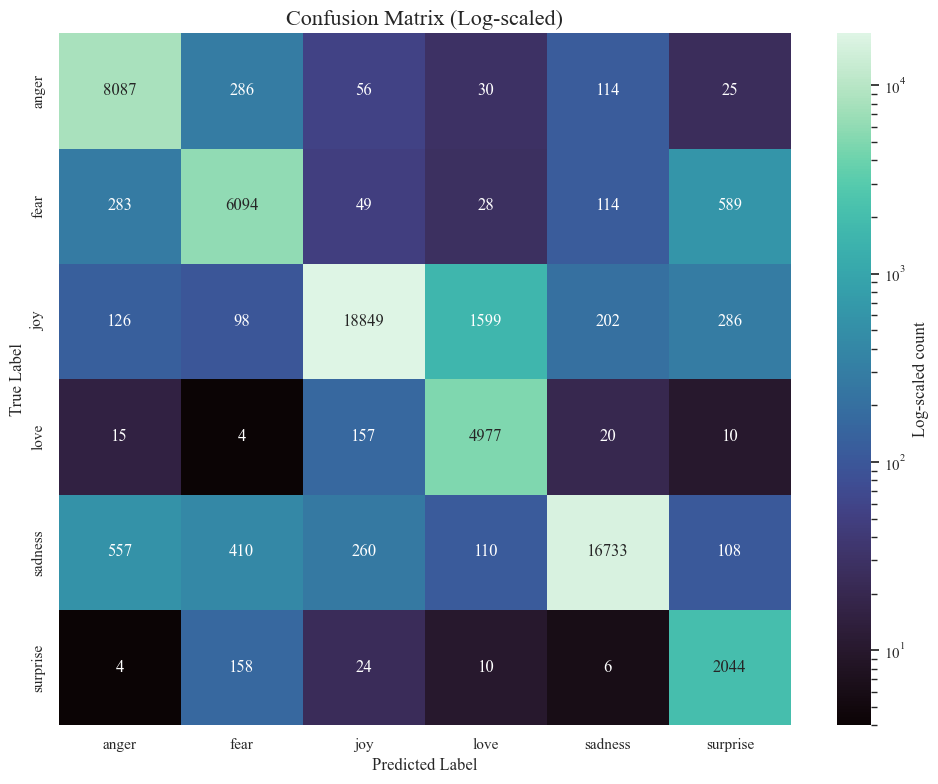

In [13]:
# confusion matrix
conf_m = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))

sns.heatmap(
    conf_m,
    annot=True,
    fmt="d",
    cmap="mako",              
    norm=LogNorm(),           
    xticklabels=label_names,
    yticklabels=label_names,
    cbar_kws={"label": "Log-scaled count"}
)

plt.title("Confusion Matrix (Log-scaled)", fontname="Times New Roman", fontsize=16)
plt.xlabel("Predicted Label", fontname="Times New Roman")
plt.ylabel("True Label", fontname="Times New Roman")

plt.tight_layout()
plt.show()

In [14]:
589/6094 * 100

9.665244502789628

In [15]:
1599/18849*100

8.48320865828426

_________

## Error Analysis

Misclassifications are inspected to determine whether errors are driven by lexical overlap, context loss, narrative complexity, ambiguity, or potential label subjectivity.

In [17]:
# predict labels
y_pred = baseline_pipeline.predict(X_test)

# predict probabilities
y_probabilities = baseline_pipeline.predict_proba(X_test)

# df for analysis
results = test_df.copy()
results["y_true"] = y_test.values
results["y_pred"] = y_pred


In [19]:
results["true_emotion"] = results["y_true"].map(id_to_emotion)
results["pred_emotion"] = results["y_pred"].map(id_to_emotion)

results[["text", "true_emotion", "pred_emotion", "pred_confidence"]].head()

,text,true_emotion,pred_emotion,pred_confidence
0,i feel rich rich like the good land and as mem...,joy,joy,0.945971
1,i wake up on work mornings im usually feeling ...,sadness,sadness,0.622496
2,i think it s part of the woman s psyche to not...,fear,fear,0.923508
3,i feel myself innocent,joy,joy,0.999884
4,i am not feeling wonderful either bit of a sor...,joy,joy,0.910236


In [20]:
# confidence
results["pred_confidence"] = y_probabilities[np.arange(len(y_pred)), y_pred]

results.head(10)

,text,label,y_true,y_pred,pred_confidence,true_emotion,pred_emotion
0,i feel rich rich like the good land and as mem...,2,2,2,0.945971,joy,joy
1,i wake up on work mornings im usually feeling ...,4,4,4,0.622496,sadness,sadness
2,i think it s part of the woman s psyche to not...,1,1,1,0.923508,fear,fear
3,i feel myself innocent,2,2,2,0.999884,joy,joy
4,i am not feeling wonderful either bit of a sor...,2,2,2,0.910236,joy,joy
5,i could feel the noise lots of low level bass ...,4,4,4,0.560687,sadness,sadness
6,i don t like people being afraid to talk aroun...,3,3,3,0.796153,love,love
7,i was oddly feeling a little melancholy all of...,4,4,4,0.979419,sadness,sadness
8,i couldnt help feeling amazed despite the fear...,5,5,5,0.988225,surprise,surprise
9,i take him at his word and why do i let those ...,4,4,4,0.965541,sadness,sadness


#### Misclassified Samples

A subset of misclassified examples is extracted for qualitative inspection. These errors are expected to cluster around semantically adjacent emotions.

In [22]:
errors = results[results["y_true"] != results["y_pred"]].copy()
print("Total test samples: ", len(results))
print("Total errors: ", len(errors))
print("Error rate: ", len(errors)/len(results))

Total test samples:  62522
Total errors:  5738
Error rate:  0.09177569495537571


In [24]:
# dominant failures
pair_counts = (
    errors.groupby(["true_emotion", "pred_emotion"]).size().sort_values(ascending=False).reset_index(name="count")
)

pair_counts.head(15)

,true_emotion,pred_emotion,count
0,joy,love,1599
1,fear,surprise,589
2,sadness,anger,557
3,sadness,fear,410
4,joy,surprise,286
5,anger,fear,286
6,fear,anger,283
7,sadness,joy,260
8,joy,sadness,202
9,surprise,fear,158


The pair-level inspection will help to isolate a single kind of confuusion so that linguistic patterns can be spotted

In [27]:
def show_pair_examples(errors_df, true_label, pred_label, n=10, sort_by="pred_confidence", ascending=False):
    subset = errors_df[
        (errors_df["true_emotion"] == true_label) & (errors_df["pred_emotion"] == pred_label)
    ].copy()

    if subset.empty:
        print(f"No examples found for {true_label} -> {pred_label}")
        return
    
    subset = subset.sort_values(sort_by, ascending=ascending)
    display(subset[["text", "true_emotion", "pred_emotion", "pred_confidence"]].head(n))
    print(f"Amount for {true_label} -> {pred_label}: {len(subset)}")

In [28]:
show_pair_examples(errors, "joy", "love", n=12)

,text,true_emotion,pred_emotion,pred_confidence
34383,i feel accepted and i feel loved by this,joy,love,0.999973
11376,i feel so passionate about with so many lovely...,joy,love,0.999933
39497,i feel so blessed to have a beautiful home a c...,joy,love,0.999898
34954,i think we both liked that a lot because it ha...,joy,love,0.999819
59539,i can t shake the feeling that june my beloved...,joy,love,0.999612
47611,i love the nostalgic feel of this sweet story,joy,love,0.999600
52905,i am often kind charming gracious considerate ...,joy,love,0.999399
5460,i feel i am a woman and mother who is artistic...,joy,love,0.999113
2601,i so understand how it feels losing someone be...,joy,love,0.999052
31440,i liked this anyway i feel faithful to these b...,joy,love,0.998869


Amount for joy -> love: 1599


In [29]:
show_pair_examples(errors, "fear", "surprise", n=15)

,text,true_emotion,pred_emotion,pred_confidence
29789,i feel around people because i am uncomfortabl...,fear,surprise,0.999968
18206,i will want to blog about in detail is that so...,fear,surprise,0.997972
24942,i am feeling a little overwhelmed but ive been...,fear,surprise,0.983627
34201,i feel is strange strange,fear,surprise,0.950686
22291,i was feeling a bit confused and overwhelmed b...,fear,surprise,0.946904
43023,i feel so weird just,fear,surprise,0.946299
16552,i feeling overwhelmed about,fear,surprise,0.945017
36432,i am not feeling as overwhelmed as i was for a...,fear,surprise,0.945017
27718,i had to do it all at once and then feeling ov...,fear,surprise,0.945017
3004,i am feeling very overwhelmed,fear,surprise,0.945017


Amount for fear -> surprise: 589


Misclassifications with high confidence may indicate systematic lexical bias or missing context.
Misclassifications with low confidence may indicate ambiguity or borderline cases where multiple
labels are plausible.

In [30]:
# high confidence mistakes
high_conf_errors = errors[errors["pred_confidence"] >= 0.80].copy()
low_conf_errors = errors[errors["pred_confidence"] <= 0.40].copy()

print("High-confidence errors:", len(high_conf_errors))
print("Low-confidence errors:", len(low_conf_errors))

High-confidence errors: 1533
Low-confidence errors: 356


In [31]:
high_conf_errors.sort_values("pred_confidence", ascending=False)[
    ["text", "true_emotion", "pred_emotion", "pred_confidence"]
].head(20)

,text,true_emotion,pred_emotion,pred_confidence
34383,i feel accepted and i feel loved by this,joy,love,0.999973
29789,i feel around people because i am uncomfortabl...,fear,surprise,0.999968
48074,i feel nervous anxious,sadness,fear,0.999954
11376,i feel so passionate about with so many lovely...,joy,love,0.999933
39497,i feel so blessed to have a beautiful home a c...,joy,love,0.999898
34954,i think we both liked that a lot because it ha...,joy,love,0.999819
48405,i feel agitated and unsure,anger,fear,0.999777
59539,i can t shake the feeling that june my beloved...,joy,love,0.999612
47611,i love the nostalgic feel of this sweet story,joy,love,0.999600
234,i am feeling overly inhibited and uncertain,sadness,fear,0.999514


In [32]:
low_conf_errors.sort_values("pred_confidence", ascending=True)[
    ["text", "true_emotion", "pred_emotion", "pred_confidence"]
].head(20)

,text,true_emotion,pred_emotion,pred_confidence
46682,after being away on a holiday for months,joy,sadness,0.222280
55912,my younger brother destroyed and gave away som...,anger,sadness,0.227476
1249,i think its the phenomenon where you can be in...,sadness,fear,0.229334
3435,getting ill,fear,anger,0.230113
59683,i just saw you recently i probably wouldn t hu...,sadness,anger,0.233974
15782,when i had gone for a boxing tournament which ...,fear,joy,0.237016
33625,while i was pushing a court roller out of a ditch,fear,sadness,0.237028
40773,when i found out that the guy i was dating at ...,anger,joy,0.238086
61361,when my husband suddenly came to see me at my ...,joy,anger,0.238194
30037,passing an exam i did not expect to pass,joy,fear,0.238823


### Error Analysis Summary

The error analysis reveals that the majority of misclassifications occur between semantically adjacent emotions rather than across distant emotional categories. This indicates that the baseline model has successfully learned coarse emotional structure but remains limited in its ability to resolve fine-grained affective distinctions.

The most frequent confusion is observed between *joy* and *love*. Qualitative inspection shows that many misclassified samples contain strong positive affect combined with relational or affiliative language (e.g., “loved”, “lovely”, “blessed”, “nostalgic”). In such cases, the distinction between joy as an affective state and love as a relational emotion becomes linguistically subtle. The model assigns high confidence to these incorrect predictions, suggesting a systematic lexical bias rather than random uncertainty.

A second prominent confusion occurs between *fear* and *surprise*. Many affected samples contain short, high-arousal expressions such as “I feel weird”, “I feel overwhelmed”, or “I feel strange”, which lack sufficient contextual cues to clearly distinguish sustained threat (fear) from sudden arousal (surprise). This overlap aligns with established findings in affective psychology, where fear and surprise share physiological and expressive components. These errors therefore reflect intrinsic ambiguity in emotional expression rather than purely model failure.

High-confidence misclassifications significantly outnumber low-confidence ones, indicating that a substantial portion of errors arise from confident but semantically coarse decision boundaries learned by the bag-of-words representation. In contrast, low-confidence errors are dominated by underspecified or ambiguous texts, suggesting that some degree of misclassification is unavoidable due to annotation subjectivity and context scarcity.

Overall, the error patterns demonstrate that the baseline model captures dominant lexical signals effectively but struggles with relational nuance, temporal dynamics, and context-dependent emotional interpretation. These findings motivate the use of sequence-aware models capable of encoding word order and longer-range dependencies in subsequent modeling stages.